# MA261 Modelling and Numerics: Assignment 2 Part 2

Student number: u2100098
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import ellipj

def npPrint(a, f={'float_kind':lambda x: "%.5e" % x}):
    print( np.array2string(a, formatter=f) )

Note: despite the assignment instructions stating to display results using floating points, I have used scientific notation since we generate errors of very large and small magnitude.

---
### Work from Previous Assignments:


In [2]:
def forwardEuler(f, Df, t0, y0, h):
    # your code to compute y1
    y1=y0+h*f(t0,y0)
    return y1

def Q11(f,Df, t0,y0, h):
    y1=y0+(h/2)*(f(t0,y0)+f(t0+h,y0+h*f(t0,y0)))
    return y1

def evolve(phi, f,Df, t0,y0, T,N):
    # your code to compute y = numpy.array( [y0,...,yN]
    n= np.arange(0,N+1,1)
    h=(T-t0)/N
    tn=n*h
    Y=np.zeros((N+1,len(y0)))
    Y[0] = y0
    
    for i in range(N):
        Y[i+1]=phi(f, Df, tn[i],Y[i],h)

    return tn,Y

def computeEocs(herr):
    # your code to compute eocs
    m = np.size(herr,0)
    eocs = np.zeros(m-1)
    h=herr[:,0]
    e=herr[:,1]
    for i in range(m-1):
        eocs[i] = (np.log(e[i+1]/e[i])) / (np.log(h[i+1]/h[i]))
    return eocs

# Edited to take N0 as an additional parameter
def maxError(method,f,Df,Y,y0,T,N0,max_error):
    for i in range(np.shape(max_error)[0]):
        error = []
        N = N0 * (2**i)
        h = T/N
        t, y = evolve(method,f,Df,0,y0,T,N)

        for j in range(np.shape(y)[0]):
            error.append(np.linalg.norm(y[j]-Y(t[j])))

        error = np.array(error)
        max_error[i,:] = [h,np.max(error)]

    return max_error

Y = lambda t: np.array([ 2*np.exp(t) / (2*np.exp(t) - 1), -2*np.exp(t) / (4*np.exp(2*t) - 4*np.exp(t) + 1) ])
f = lambda t,y: np.array([y[1],y[1]*(1-2*y[0])])

T=10
y0 = np.array([2,-2])

---
### Q 2.0. Quiz Work

(1) Function that implements Newton's method, followed by some testing.

In [3]:
def newton(F, DF, x0, epsilon, K):
    x = x0
    k = 0
    while k < K:
        delta = np.linalg.solve(DF(x), -F(x))
        x = x + delta
        k += 1
        if np.linalg.norm(F(x)) < epsilon:
            break
    return x, k

In [4]:
x,k = newton( lambda y: np.cos(y/2), 
              lambda y: np.array([-np.sin(y/2)/2]),
              np.array([3.]), 1e-8, 100)
relErr = np.linalg.norm(x-np.pi) / np.pi
if relErr<1e-10:
  print("CORRECT:\n relative error < 1e-10")
else:
  print("value %g is incorrect\n relative error is %g" % (x,relErr) )

CORRECT:
 relative error < 1e-10


In [5]:
A = np.array([ [1,2], [3,1] ]);
root = np.array([1,1]);
b = np.array([3,4]);

x,k = newton( lambda y: A.dot(y)-b,
              lambda y: A,
              np.array([0.,0.]), 1e-8, 100)
absErr = np.linalg.norm(x-root)
print(absErr)
print(k)
if absErr<1e-8 and k==1:
    print(absErr)
    print("CORRECT:\n absolute error < 1e-8 computed in single step")
else:
    print("Computed root:",x)
    print("Absolute error is",absErr," Steps needed",k)

0.0
1
0.0
CORRECT:
 absolute error < 1e-8 computed in single step


(2) Function that performs one step of the Backwards Euler method.

In [6]:
def backwardEuler(f, Df, t0, y0, h):
    F = lambda delta: delta - f(t0+h,y0+h*delta)
    DF = lambda delta: np.eye(len(y0))-h*Df(t0+h,y0+h*delta)
    x,k=newton(F,DF,f(t0+h,y0),h*h*1e-5,1000)
    return y0+h*x

In [7]:
t,y = evolve( backwardEuler, lambda t,y: -10*y,
                           lambda t,y: np.array([-10]),
                           0,np.array([1.]), 1,20)
print("%d "     % len(y), end="")
print("%1.3e  " % y[0],   end="")
print("%1.3e  " % y[-1],  end="")


21 1.000e+00  3.007e-04  

---
### Q 2.1. Implementing the Crank-Nicholson Method and Comparing it to Previously Seen Methods

Here we implement the Crank-Nicholson method and compute the maximum errors and experimental orders of convergence. We produce similar values for the forward Euler and backward Euler methods, as well as the approximation given in Q1.1 from Assignment 1.

In [8]:
def crankNicholson(f, Df, t0, y0, h):
    F = lambda x: x - 1/2*(f(t0,y0)+f(t0+h,y0+h*x))
    DF = lambda x: np.eye(len(y0)) - (1/2)*h*Df(t0+h,y0+h*x)
    x,k = newton(F,DF,f(t0+h,y0),h**2*1e-5,1000)
    return y0+h*x

In [9]:
t,y = evolve( crankNicholson, lambda t,y: -10*y,
                           lambda t,y: np.array([-10]),
                           0,np.array([1.]), 1,20)
print("%d "     % len(y), end="")
print("%1.3e  " % y[0],   end="")
print("%1.3e  " % y[-1],  end="")


21 1.000e+00  3.656e-05  

In [10]:
max_error1 = np.zeros((10,2))
max_error1 = maxError(forwardEuler,f,0,Y,y0,T,25,max_error1)
max_error2 = np.zeros((10,2))
max_error2 = maxError(Q11,f,0,Y,y0,T,25,max_error2)

Df = lambda t,y: np.array([[0,1],[-2*y[1],1-2*y[0]]])

max_error3 = np.zeros((10,2))
max_error3 = maxError(backwardEuler,f,Df,Y,y0,T,25,max_error3)
max_error4 = np.zeros((10,2))
max_error4 = maxError(crankNicholson,f,Df,Y,y0,T,25,max_error4)

errorData = np.column_stack((max_error1[:, 0],max_error1[:, 1],np.insert(computeEocs(max_error1),0,0),max_error2[:, 1],np.insert(computeEocs(max_error2),0,0),max_error3[:, 1],np.insert(computeEocs(max_error3),0,0),max_error4[:, 1],np.insert(computeEocs(max_error4),0,0)))
errorDF = pd.DataFrame(errorData,columns =['h','FE error','FE eocs','Q11 error','Q11 eocs','BE error','BE eocs','CN error','CN eocs']).style.format("{:.6e}")
errorDF.set_caption('Table to show the maximum errors and experimental orders of convergence for the 4 methods for each value of h').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF)

,h,FE error,FE eocs,Q11 error,Q11 eocs,BE error,BE eocs,CN error,CN eocs
0,4.000000e-01,1.197520e+00,0.000000e+00,2.336009e-01,0.000000e+00,4.596387e+00,0.000000e+00,1.853746e-01,0.000000e+00
1,2.000000e-01,3.849013e-01,1.637490e+00,5.724377e-02,2.028855e+00,1.949440e-01,4.559369e+00,4.250296e-02,2.124808e+00
2,1.000000e-01,1.424462e-01,1.434071e+00,1.252991e-02,2.191742e+00,1.058020e-01,8.816923e-01,1.013313e-02,2.068484e+00
3,5.000000e-02,6.525497e-02,1.126258e+00,2.894328e-03,2.114076e+00,5.635233e-02,9.088200e-01,2.522717e-03,2.006029e+00
4,2.500000e-02,3.135656e-02,1.057320e+00,6.889803e-04,2.070694e+00,2.914622e-02,9.511664e-01,6.287615e-04,2.004394e+00
5,1.250000e-02,1.538350e-02,1.027384e+00,1.680073e-04,2.035939e+00,1.483127e-02,9.746664e-01,1.571657e-04,2.000226e+00
6,6.250000e-03,7.620535e-03,1.013419e+00,4.148271e-05,2.017942e+00,7.482302e-03,9.870884e-01,3.928423e-05,2.000265e+00
7,3.125000e-03,3.792678e-03,1.006676e+00,1.030578e-05,2.009056e+00,3.758094e-03,9.934809e-01,9.820607e-06,2.000066e+00
8,1.562500e-03,1.891968e-03,1.003329e+00,2.568356e-06,2.004537e+00,1.883324e-03,9.967198e-01,2.455153e-06,1.999999e+00
9,7.812500e-04,9.448989e-04,1.001655e+00,6.410798e-07,2.002270e+00,9.427381e-04,9.983527e-01,6.137861e-07,2.000005e+00


(Note I have set the first entry of each EOC column to 0 as it is undefined here.)

---
### Q 2.2. Approximating Hamiltonian Systems: Harmonic Oscillator and Duffy Equation


In [11]:
k=0.8
y0 = np.array([0,1])
T=40

# Calculated by solving the system of ODEs, reducing to a 2nd order ODE
def Yr2(t):
    return np.array([np.sin(t),np.cos(t)]) # (x(t),p(t))

# Using known solution to the Duffy equation as given in the assignment, the elliptic Jacobi functions
def Yr4(t):
    sn, cn, dn, _ = ellipj(t,k*k)
    return np.array([sn,cn*dn]) # (x(t),p(t))

fr2 = lambda t,y: np.array([y[1],-y[0]])
Dfr2 = lambda t,y: np.array([[0,1],[-1,0]])

fr4 = lambda t,y: np.array([y[1],(-1.64)*y[0]+1.28*(y[0]**3)])
Dfr4 = lambda t,y: np.array([[0,1],[(-1.64)+3.84*(y[0]**2),0]])

max_error5 = np.zeros((11,2))
max_error5 = maxError(Q11,fr2,0,Yr2,y0,T,150,max_error5)
max_error6 = np.zeros((11,2))
max_error6 = maxError(crankNicholson,fr2,Dfr2,Yr2,y0,T,150,max_error6)
max_error7 = np.zeros((11,2))
max_error7 = maxError(backwardEuler,fr2,Dfr2,Yr2,y0,T,150,max_error7)

max_error8 = np.zeros((11,2))
max_error8 = maxError(Q11,fr4,0,Yr4,y0,T,150,max_error8)
max_error9 = np.zeros((11,2))
max_error9 = maxError(crankNicholson,fr4,Dfr4,Yr4,y0,T,150,max_error9)
max_error10 = np.zeros((11,2))
max_error10 = maxError(backwardEuler,fr4,Dfr4,Yr4,y0,T,150,max_error10)

errorData2 = np.column_stack((max_error5[:, 0],max_error5[:, 1],np.insert(computeEocs(max_error5),0,0),max_error6[:, 1],np.insert(computeEocs(max_error6),0,0),max_error7[:, 1],np.insert(computeEocs(max_error7),0,0),max_error8[:, 1],np.insert(computeEocs(max_error8),0,0),max_error9[:, 1],np.insert(computeEocs(max_error9),0,0),max_error10[:, 1],np.insert(computeEocs(max_error10),0,0)))
errorDF2 = pd.DataFrame(errorData2,columns =['h','Q11 error r=2','Q11 eocs r=2','CN error r=2','CN eocs r=2','BE error r=2','BE eocs r=2','Q11 error r=4','Q11 eocs r=4','CN error r=4','CN eocs r=4','BE error r=4','BE eocs r=4']).style.format("{:.6e}")
errorDF2.set_caption('Table to show the maximum errors and experimental orders of convergence for the 3 methods, with r=2 and r=4').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF2)

/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3036203354.py:17: RuntimeWarning: overflow encountered in double_scalars
  fr4 = lambda t,y: np.array([y[1],(-1.64)*y[0]+1.28*(y[0]**3)])
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3036203354.py:17: RuntimeWarning: invalid value encountered in double_scalars
  fr4 = lambda t,y: np.array([y[1],(-1.64)*y[0]+1.28*(y[0]**3)])


,h,Q11 error r=2,Q11 eocs r=2,CN error r=2,CN eocs r=2,BE error r=2,BE eocs r=2,Q11 error r=4,Q11 eocs r=4,CN error r=4,CN eocs r=4,BE error r=4,BE eocs r=4
0,2.666667e-01,4.920079e-01,0.000000e+00,2.340031e-01,0.000000e+00,9.964574e-01,0.000000e+00,nan,0.000000e+00,1.671326e+00,0.000000e+00,1.245470e+00,0.000000e+00
1,1.333333e-01,1.191125e-01,2.046356e+00,5.909313e-02,1.985465e+00,9.309638e-01,9.808309e-02,1.586126e+00,nan,5.155174e-01,1.696900e+00,1.391192e+00,-1.596314e-01
2,6.666667e-02,2.964800e-02,2.006318e+00,1.480481e-02,1.996924e+00,7.362502e-01,3.385289e-01,3.242903e-01,2.290150e+00,1.270689e-01,2.020410e+00,1.651777e+00,-2.476968e-01
3,3.333333e-02,7.407921e-03,2.000794e+00,3.703084e-03,1.999267e+00,4.865085e-01,5.977310e-01,5.871152e-02,2.465570e+00,3.153783e-02,2.010456e+00,1.777689e+00,-1.059844e-01
4,1.666667e-02,1.851863e-03,2.000091e+00,9.258873e-04,1.999819e+00,2.834529e-01,7.793563e-01,1.201850e-02,2.288387e+00,7.868262e-03,2.002966e+00,1.797906e+00,-1.631421e-02
5,8.333333e-03,4.629630e-04,2.000009e+00,2.314791e-04,1.999955e+00,1.535157e-01,8.847222e-01,2.677790e-03,2.166141e+00,1.966001e-03,2.000781e+00,1.865162e+00,-5.298346e-02
6,4.166667e-03,1.157407e-04,2.000000e+00,5.787022e-05,1.999989e+00,7.995523e-02,9.411223e-01,6.288111e-04,2.090344e+00,4.914425e-04,2.000169e+00,1.940380e+00,-5.703867e-02
7,2.083333e-03,2.893518e-05,2.000000e+00,1.446758e-05,1.999997e+00,4.081050e-02,9.702521e-01,1.521329e-04,2.047295e+00,1.228579e-04,2.000032e+00,1.535497e+00,3.376332e-01
8,1.041667e-03,7.233796e-06,2.000000e+00,3.616898e-06,1.999999e+00,2.061781e-02,9.850489e-01,3.739999e-05,2.024222e+00,3.071429e-05,2.000008e+00,1.013199e+00,5.997892e-01
9,5.208333e-04,1.808449e-06,2.000000e+00,9.042245e-07,2.000000e+00,1.036260e-02,9.925052e-01,9.270870e-06,2.012261e+00,7.678563e-06,2.000002e+00,5.788232e-01,8.077223e-01


(Again, note the first entry of each EOC column is set to 0 as it is undefined here.)

Here we can see that the EOCS for the Q11 and Crank-Nicholson method seem to converge to 2, indicating that these methods have order 2 (as we already know), whereas the backward Euler method has order 1, which is supported by our squence of EOCs converging to 1. 

The maximum errors for Crank-Nicholson method converge to 0 faster than the maximum errors for the method in Q11; this will also be discussed later on in the report.

/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3036203354.py:17: RuntimeWarning: overflow encountered in double_scalars
  fr4 = lambda t,y: np.array([y[1],(-1.64)*y[0]+1.28*(y[0]**3)])
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3036203354.py:17: RuntimeWarning: invalid value encountered in double_scalars
  fr4 = lambda t,y: np.array([y[1],(-1.64)*y[0]+1.28*(y[0]**3)])


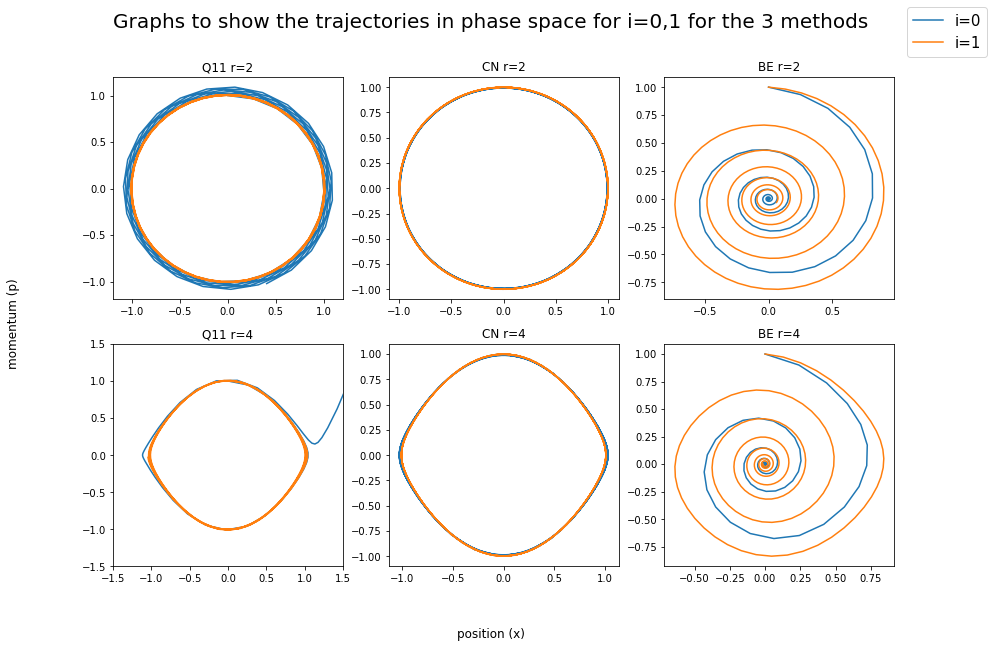

In [12]:
def trajectory(method,f,Df,t0,y0,T):
    A = evolve(method,f,Df,t0,y0,T,150)
    B = evolve(method,f,Df,t0,y0,T,300)
    
    x1=np.zeros(151)
    y1=np.zeros(151)
    
    x2=np.zeros(301)
    y2=np.zeros(301)
    
    for i in range(151):
        x1[i]=A[1][i][0]
        y1[i]=A[1][i][1]
        
    for i in range(301):
        x2[i]=B[1][i][0]
        y2[i]=B[1][i][1]
    
    return np.array([x1,y1,x2,y2],dtype=object)

fig, ax = plt.subplots(2,3, figsize=(14,9))

methods = [Q11,crankNicholson,backwardEuler]
titles = ['Q11 r=2','CN r=2','BE r=2','Q11 r=4','CN r=4','BE r=4']

## Failed attempt to generate the trajectories array using a for loop. Will try again later
# trajectories = np.array([])

# for i in range(6):
#     if i<3:
#         trajectories = np.concatenate(trajectories,trajectory(methods[i],fr2,Dfr2,0,y0,T))
#         #trajectories = np.column_stack((trajectories,trajectory(methods[i],fr2,Dfr2,0,y0,T)))
#         #trajectories[i]=trajectory(methods[i],fr2,Dfr2,0,y0,T)
#     else:
#         trajectories = np.concatenate(trajectories,trajectory(methods[i-3],fr4,Dfr4,0,y0,T))
#         #trajectories = np.column_stack((trajectories,trajectory(methods[i-3],fr4,Dfr4,0,y0,T)))
#         #trajectories[i]=trajectory(methods[i-3],fr4,Dfr4,0,y0,T)

t1=trajectory(Q11,fr2,Dfr2,0,y0,T)
t2=trajectory(crankNicholson,fr2,Dfr2,0,y0,T)
t3=trajectory(backwardEuler,fr2,Dfr2,0,y0,T)
t4=trajectory(Q11,fr4,Dfr4,0,y0,T)
t5=trajectory(crankNicholson,fr4,Dfr4,0,y0,T)
t6=trajectory(backwardEuler,fr4,Dfr4,0,y0,T)
trajectories = np.array([t1,t2,t3,t4,t5,t6],dtype=object)

## Old code to plot trajectories; replaced by a nice for loop
#t1=trajectory(Q11,fr2,Dfr2,0,y0,T)
# ax[0,0].plot(t1[0],t1[1],label="i=0")
# ax[0,0].plot(t1[2],t1[3],label="i=1")
# ax[0,0].title.set_text('Q11 r=2')

#t2=trajectory(crankNicholson,fr2,Dfr2,0,y0,T)
# ax[0,1].plot(t2[0],t2[1],label="i=0")
# ax[0,1].plot(t2[2],t2[3],label="i=1")
# ax[0,1].title.set_text('CN r=2')

#t3=trajectory(backwardEuler,fr2,Dfr2,0,y0,T)
# ax[0,2].plot(t3[0],t3[1],label="i=0")
# ax[0,2].plot(t3[2],t3[3],label="i=1")
# ax[0,2].title.set_text('BE r=2')

#t4=trajectory(Q11,fr4,Dfr4,0,y0,T)
# ax[1,0].plot(t4[0],t4[1],label="i=0")
# ax[1,0].plot(t4[2],t4[3],label="i=1")
# ax[1,0].title.set_text('Q11 r=4')

#t5=trajectory(crankNicholson,fr4,Dfr4,0,y0,T)
# ax[1,1].plot(t5[0],t5[1],label="i=0")
# ax[1,1].plot(t5[2],t5[3],label="i=1")
# ax[1,1].title.set_text('CN r=4')

#t6=trajectory(backwardEuler,fr4,Dfr4,0,y0,T)
# ax[1,2].plot(t6[0],t6[1],label="i=0")
# ax[1,2].plot(t6[2],t6[3],label="i=1")
# ax[1,2].title.set_text('BE r=4')

# Limiting the axis scales so the graph is clear
ax[1,0].set_xlim([-1.5, 1.5])
ax[1,0].set_ylim([-1.5, 1.5])

# Managed to use a for loop to plot the trajectories in the correct subplots
for i in range(2):
    for j in range(3):
        ax[i,j].plot(trajectories[3*i+j][0],trajectories[3*i+j][1],label="i=0")
        ax[i,j].plot(trajectories[3*i+j][2],trajectories[3*i+j][3],label="i=1")
        ax[i,j].title.set_text(titles[3*i+j])

fig.suptitle("Graphs to show the trajectories in phase space for i=0,1 for the 3 methods", fontsize=20)
fig.supxlabel('position (x)')
fig.supylabel('momentum (p)')
fig.legend(labels=['i=0','i=1'],fontsize=15)
plt.show()

---
### Q 2.3. Semi-implicit Euler Method and Relative Error


In [13]:
def semiImplicitEuler(f,Df,t0,y0,h):
    x1 = y0[0] + h*y0[1]
    p1 = y0[1] + h*f(t0,np.array([x1,y0[1]]))[1]
    return np.array([x1,p1])

In [14]:
max_error11 = np.zeros((11,2))
max_error11 = maxError(semiImplicitEuler,fr2,Dfr2,Yr2,y0,T,150,max_error11)
max_error12 = np.zeros((11,2))
max_error12 = maxError(semiImplicitEuler,fr4,Dfr4,Yr4,y0,T,150,max_error12)

errorData3 = np.column_stack((max_error11[:, 0],max_error11[:, 1],np.insert(computeEocs(max_error11),0,0),max_error12[:, 1],np.insert(computeEocs(max_error12),0,0)))
errorDF3 = pd.DataFrame(errorData3,columns =['h','SE error r=2','SE eocsr=2','SE error r=4','SE eocs r=4']).style.format("{:.6e}")
errorDF3.set_caption('Table to show the maximum errors and experimental orders of convergence for the semi-implicit euler method for r=2 and r=4').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF3)

,h,SE error r=2,SE eocsr=2,SE error r=4,SE eocs r=4
0,2.666667e-01,2.516098e-01,0.000000e+00,1.806380e+00,0.000000e+00
1,1.333333e-01,9.588617e-02,1.391794e+00,5.503766e-01,1.714610e+00
2,6.666667e-02,4.063059e-02,1.238756e+00,1.347051e-01,2.030615e+00
3,3.333333e-02,1.848764e-02,1.136005e+00,3.330688e-02,2.015912e+00
4,1.666667e-02,8.788152e-03,1.072930e+00,8.303854e-03,2.003967e+00
5,8.333333e-03,4.280311e-03,1.037844e+00,2.971172e-03,1.482749e+00
6,4.166667e-03,2.111746e-03,1.019280e+00,1.487067e-03,9.985623e-01
7,2.083333e-03,1.048769e-03,1.009739e+00,7.439090e-04,9.992717e-01
8,1.041667e-03,5.226089e-04,1.004893e+00,3.720478e-04,9.996383e-01
9,5.208333e-04,2.608605e-04,1.002453e+00,1.860472e-04,9.998191e-01


Here we can see that the sequence of EOCs (for both r=2 and r=4) seems to converge to 1, indicating that the semi-implicit Euler method has order 1. We can also see that the maximum errors converge to 0 much faster than the backwards Euler method which is also of order 1, but not as fast as the Q11 and Crank-Nicholson methods which have order 2.

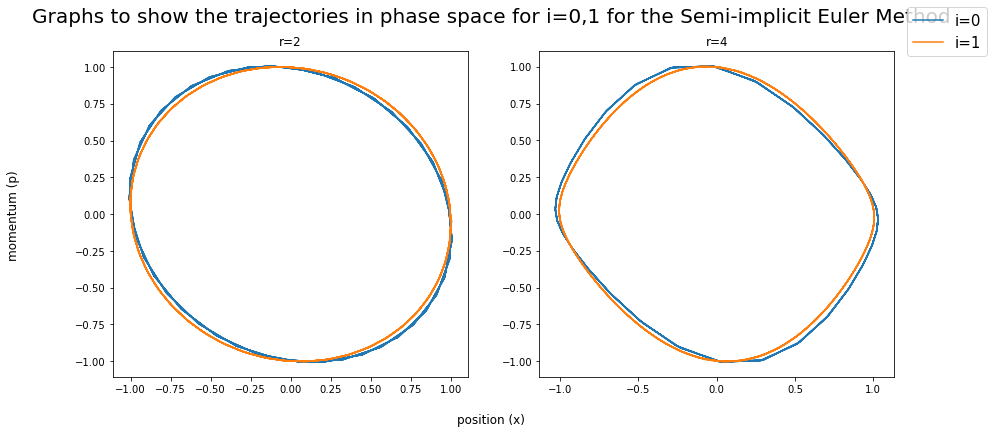

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

t7=trajectory(semiImplicitEuler,fr2,Dfr2,0,y0,T)
ax[0].plot(t7[0],t7[1],label="i=0")
ax[0].plot(t7[2],t7[3],label="i=1")
ax[0].title.set_text('r=2')

t8=trajectory(semiImplicitEuler,fr4,Dfr4,0,y0,T)
ax[1].plot(t8[0],t8[1],label="i=0")
ax[1].plot(t8[2],t8[3],label="i=1")
ax[1].title.set_text('r=4')

fig.suptitle("Graphs to show the trajectories in phase space for i=0,1 for the Semi-implicit Euler Method", fontsize=20)
fig.legend(labels=['i=0','i=1'],fontsize=15)
fig.supxlabel('position (x)')
fig.supylabel('momentum (p)')
plt.show()

In [16]:
def Ham2(x,p):
    return 0.5*p**2+0.5*(k**2+1)*x**2-0.5*(k**2)*x**2

def Ham4(x,p):
    return 0.5*p**2+0.5*(k**2+1)*x**2-0.5*(k**2)*x**4

def function2(t,y):
    r=2
    return (np.array([y[1],(r*(k**2)/2)*(y[0]**(r-1))-(k**2+1)*y[0]]))

def der2(t,y):
    r=2
    return(np.array([[0,1],[-k**2-1+(r*(r-1)*k**2)/2*(y[0]**(r-2)),0]]))

def function4(t,y):
    r=4
    return (np.array([y[1],(r*(k**2)/2)*(y[0]**(r-1))-(k**2+1)*y[0]]))

def der4(t,y):
    r=4
    return(np.array([[0,1],[-k**2-1+(r*(r-1)*k**2)/2*(y[0]**(r-2)),0]]))

def relativeErrors(h,errors,method,function,derivative,hamiltonian,T,t0,y0):
    for i in range(11):
        N = 150*2**i
        h[i]=T/N
        methodArray = evolve(method,function,derivative,t0,y0,T,N)
        for j in range(N):
            y=abs(hamiltonian(methodArray[1][j][0],methodArray[1][j][1])-hamiltonian(y0[0],y0[1]))/abs(hamiltonian(y0[0],y0[1]))
            if y>errors[i]:
                errors[i]=y
    return np.array([h, errors])

In [17]:
ar2 = np.zeros(11)
br2 = np.zeros(11)
cr2 = np.zeros(11)
dr2 = np.zeros(11)
ar4 = np.zeros(11)
br4 = np.zeros(11)
cr4 = np.zeros(11)
dr4 = np.zeros(11)
h = np.zeros(11)

errorData4 = np.column_stack((relativeErrors(h,ar2,Q11,function2,der2,Ham2,T,0,y0)[0],relativeErrors(h,ar2,Q11,function2,der2,Ham2,T,0,y0)[1],relativeErrors(h,br2,crankNicholson,function2,der2,Ham2,T,0,y0)[1],relativeErrors(h,cr2,backwardEuler,function2,der2,Ham2,T,0,y0)[1],relativeErrors(h,dr2,semiImplicitEuler,function2,der2,Ham2,T,0,y0)[1],relativeErrors(h,ar4,Q11,function4,der4,Ham4,T,0,y0)[1],relativeErrors(h,br4,crankNicholson,function4,der4,Ham4,T,0,y0)[1],relativeErrors(h,cr4,backwardEuler,function4,der4,Ham4,T,0,y0)[1],relativeErrors(h,dr4,semiImplicitEuler,function4,der4,Ham4,T,0,y0)[1]))
errorDF4 = pd.DataFrame(errorData4,columns =['h','Q11 Ham error r=2','CN Ham error r=2','BE Ham error r=2','SE Ham error r=2','Q11 Ham error r=4','CN Ham error r=4','BE Ham error r=4','SE Ham error r=4']).style.format("{:.6e}")
errorDF4.set_caption('Table to show the maximum relative errors in the Hamiltonian for the 4 methods').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF4)

/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3200260174.py:17: RuntimeWarning: overflow encountered in double_scalars
  return (np.array([y[1],(r*(k**2)/2)*(y[0]**(r-1))-(k**2+1)*y[0]]))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3200260174.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return (np.array([y[1],(r*(k**2)/2)*(y[0]**(r-1))-(k**2+1)*y[0]]))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3200260174.py:5: RuntimeWarning: overflow encountered in double_scalars
  return 0.5*p**2+0.5*(k**2+1)*x**2-0.5*(k**2)*x**4
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/3200260174.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5*p**2+0.5*(k**2+1)*x**2-0.5*(k**2)*x**4


,h,Q11 Ham error r=2,CN Ham error r=2,BE Ham error r=2,SE Ham error r=2,Q11 Ham error r=4,CN Ham error r=4,BE Ham error r=4,SE Ham error r=4
0,2.666667e-01,2.071310e-01,1.665335e-15,9.999641e-01,1.538396e-01,4.756569e+230,1.839224e-02,9.999999e-01,1.682538e-01
1,1.333333e-01,2.390501e-02,2.664535e-15,9.948505e-01,7.142441e-02,2.810778e-02,4.503955e-03,9.996093e-01,7.642963e-02
2,6.666667e-02,2.962397e-03,1.554312e-15,9.297942e-01,3.448274e-02,3.994322e-03,1.120580e-03,9.722812e-01,3.651316e-02
3,3.333333e-02,3.701302e-04,1.776357e-15,7.359146e-01,1.694891e-02,6.378451e-04,2.798122e-04,7.772426e-01,1.785257e-02
4,1.666667e-02,4.627808e-05,2.664535e-15,4.863927e-01,8.403348e-03,1.146536e-04,6.993237e-05,4.534391e-01,8.827914e-03
5,8.333333e-03,5.785848e-06,2.220446e-15,2.834106e-01,4.184016e-03,2.307004e-05,1.748153e-05,2.213910e-01,4.389656e-03
6,4.166667e-03,7.233045e-07,5.329071e-15,1.535024e-01,2.087683e-03,5.068741e-06,4.370346e-06,1.047402e-01,2.188790e-03
7,2.083333e-03,9.041775e-08,5.329071e-15,7.995143e-02,1.042752e-03,1.179870e-06,1.092591e-06,4.970816e-02,1.092890e-03
8,1.041667e-03,1.130253e-08,9.103829e-15,4.080948e-02,5.211047e-04,2.840561e-07,2.731481e-07,2.447594e-02,5.460695e-04
9,5.208333e-04,1.412834e-09,8.437695e-15,2.061755e-02,2.604845e-04,6.965035e-08,6.828704e-08,1.208885e-02,2.729409e-04


Here we have the maximum relative errors in the Hamiltonian for all 4 methods. We can see that all the errors are converging to 0, with the Crank-Nicholson method having the fastest rate of convergence for r=2, followed by the Q11 method, semi-implicit Euler and finally the backward Euler method. Furthermore, the Crank-Nicholson method had the fastest rate of convergence for r=4 (albeit with a similar rate to the Q11 method), again followed by the semi-implicit Euler and the backward Euler.

The faster rate of convergence for the Crank-Nicholson and Q11 methods is explained by the fact that they are second-order methods whereas the backward Euler and semi-implicit Euler methods are first-order, as shown by the sequence of EOCs discussed earlier.

This data, as a whole, indicates that the Crank-Nicholson method is the most effect approximation in terms of convergence.

---
### Q 2.4. Fully Implicit Method

This section has errors; I'm not sure what's going wrong.


$V(x_n +\delta h) \approx  V(x_n)$ for small h. Solving the resulting quadratic gives $\delta = p_n$. So my inital guess is $p_n$.


In [18]:
def newtonScalar(F,DF,x0,eps,K):
    x=x0
    k=0
    while k<K:
        dx = F(x)/DF(x)
        x += dx
        k += 1
        if np.linalg.norm(F(x))<eps:
            break
        return x,k

In [19]:
def fullyImplicitEuler(f,Df,t0,y0,h):
    x0=y0[0]
    p0=y0[1]
    F = lambda d: d - p0 + 1/(2*d) *(V(x0+h*d)-V(x0))
    DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))
    x,k = newtonScalar(F,DF,p0,h*h*1e-5,1000)
    x1 = x0 +h*x
    #p1 = p0+h*(V(x1)-V(x0))/(x1-x0)
    p1 = p0 - h*(V(x1)-V(x0))/(x1-x0)
    return np.array([x1,p1])

In [20]:
def f22(t,y):
    return np.array([y[1],(-k**2-1)*y[0]+(r/2)*(k**2)*(y[0]**r-1)])

def Df22(t,y):
    return np.array([[0,1],[(((-k**2-1)+r*(r-1)*(k**2))/2)*(y[0]**(r-2)),0]])

In [21]:
k=0.8
r=2
V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
DV = lambda x: ((k**2)+1)*x - ((r*(k**2))/2)*(x**(r-1))

YQ24 = lambda t: np.array([np.sin(t),np.cos(t)])
y0=np.array([V(1),1])

In [22]:
r=2
max_error13 = np.zeros((11,2))
# max_error13 = maxError(fullyImplicitEuler,function2,der2,Yr2,y0,T,150,max_error13)
max_error13 = maxError(fullyImplicitEuler,f22,Df22,Yr2,y0,T,150,max_error13)
t8=trajectory(fullyImplicitEuler,fr4,Dfr4,0,y0,T)
r=4
max_error14 = np.zeros((11,2))
max_error14 = maxError(fullyImplicitEuler,function4,der4,Yr4,y0,T,150,max_error14)
t8=trajectory(fullyImplicitEuler,fr4,Dfr4,0,y0,T)

errorData5 = np.column_stack((max_error13[:, 0],max_error13[:, 1],np.insert(computeEocs(max_error13),0,0),max_error14[:, 1],np.insert(computeEocs(max_error14),0,0),relativeErrors(h,np.zeros(11),fullyImplicitEuler,function2,der2,Ham2,T,0,y0)[1],relativeErrors(h,np.zeros(11),fullyImplicitEuler,function4,der4,Ham4,T,0,y0)[1]))
errorDF5 = pd.DataFrame(errorData5,columns =['h','FIE error r=2','FIE eocs r=2','FIE error r=4','FIE eocs r=4','FIE Ham r=2','FIE Ham r=4']).style.format("{:.6e}")
errorDF5.set_caption('Table to show the repeated experiments for the FI method').set_table_styles([{
    'selector': 'caption',
    'props': [('font-size', '20px')]
}])
display(errorDF5)

/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:3: RuntimeWarning: overflow encountered in double_scalars
  V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:3: RuntimeWarning: invalid value encountered in double_scalars
  V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/791054859.py:5: RuntimeWarning: overflow encountered in double_scalars
  DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:4: RuntimeWarning: overflow encountered in double_scalars
  DV = lambda x: ((k**2)+1)*x - ((r*(k**2))/2)*(x**(r-1))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/791054859.py:5: RuntimeWarning: invalid value encountered in double_scalars
  DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))
/

,h,FIE error r=2,FIE eocs r=2,FIE error r=4,FIE eocs r=4,FIE Ham r=2,FIE Ham r=4
0,2.666667e-01,2.165313e+02,0.000000e+00,nan,0.000000e+00,inf,inf
1,1.333333e-01,1.566687e+01,3.788786e+00,nan,nan,8.922639e+291,8.141094e+291
2,6.666667e-02,3.452362e+00,2.182062e+00,nan,nan,1.540862e+240,1.405896e+240
3,3.333333e-02,1.376727e+00,1.326341e+00,nan,nan,4.741854e+222,4.326509e+222
4,1.666667e-02,8.079339e-01,7.689331e-01,nan,nan,4.084877e+194,3.727077e+194
5,8.333333e-03,6.204078e-01,3.810205e-01,nan,nan,inf,inf
6,4.166667e-03,5.516072e-01,1.695756e-01,nan,nan,4.199363e+252,3.831536e+252
7,2.083333e-03,5.236452e-01,7.505167e-02,nan,nan,4.470172e+242,4.078624e+242
8,1.041667e-03,5.112841e-01,3.446450e-02,nan,nan,4.414776e+203,4.028080e+203
9,5.208333e-04,5.055077e-01,1.639195e-02,nan,nan,3.185363e+291,2.906353e+291


But this isn't right :/ I think my fully implicit Euler method function is wrong.

/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:3: RuntimeWarning: overflow encountered in double_scalars
  V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:3: RuntimeWarning: invalid value encountered in double_scalars
  V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/791054859.py:5: RuntimeWarning: overflow encountered in double_scalars
  DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:4: RuntimeWarning: overflow encountered in double_scalars
  DV = lambda x: ((k**2)+1)*x - ((r*(k**2))/2)*(x**(r-1))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/791054859.py:5: RuntimeWarning: invalid value encountered in double_scalars
  DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))


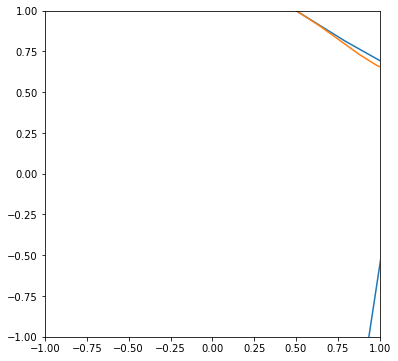

/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:3: RuntimeWarning: overflow encountered in double_scalars
  V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:3: RuntimeWarning: invalid value encountered in double_scalars
  V = lambda x: (((k**2)+1)/2)*(x**2) - ((k**2)/2)*(x**r)
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/791054859.py:5: RuntimeWarning: overflow encountered in double_scalars
  DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/1239872982.py:4: RuntimeWarning: overflow encountered in double_scalars
  DV = lambda x: ((k**2)+1)*x - ((r*(k**2))/2)*(x**(r-1))
/var/folders/__/qz247c355dj5m5hg_r7z6vh80000gn/T/ipykernel_40358/791054859.py:5: RuntimeWarning: invalid value encountered in double_scalars
  DF = lambda d: 1+ 1/(2*d**2) *(h*d *DV(x0+h*d)-V(x0+h*d)+V(x0))


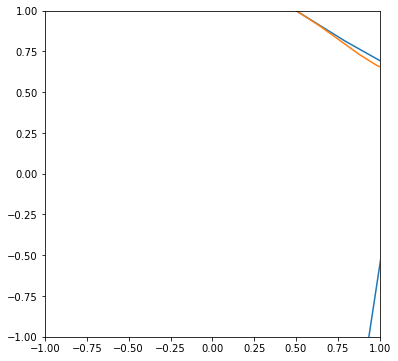

In [23]:
t9=trajectory(fullyImplicitEuler,f22,Df22,0,y0,T)

plt.figure(figsize=(6, 6))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(t9[0],t9[1],label="i=0")
plt.plot(t9[2],t9[3],label="i=1")
#plt.legend(fontsize=12)
plt.show()

t10=trajectory(fullyImplicitEuler,function4,der4,0,y0,T)

plt.figure(figsize=(6, 6))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(t10[0],t10[1],label="i=0")
plt.plot(t10[2],t10[3],label="i=1")
#plt.legend(fontsize=12)
plt.show()